In [1]:
import os, glob
from pathlib import Path

from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
data_dir = 'D:/ITU/Spring 2020/Deep Learning/Assignments/Assignment 05/Part 02/A_05_Part_02_Dataset/A_05_Part_02_Dataset'
batch_size = 1

In [3]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


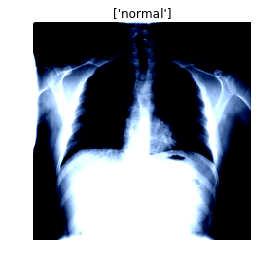

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# One hot encoding for Multilabel Classification

In [5]:
def get_onehot_encodings(classes):
    encodings = []
    for class_ in classes:
        if class_ == 0:
            value = torch.Tensor([1, 0, 1])
        elif class_ == 1:
            value = torch.Tensor([0, 1, 0])
        elif class_ == 2:
            value = torch.Tensor([0, 0, 1])
        encodings.append(value)
    b = torch.Tensor(classes.size(0), 3)
    torch.cat(encodings, dim=0, out=b)
    final_encodings = torch.reshape(b, (classes.size(0), 3))
    return final_encodings

In [6]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# Freeze training for all layers
for param in vgg16.parameters():
    param.require_grad = False
num_features = vgg16.classifier[0].in_features  # 25088
features = [] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))])
print(features)
vgg16.classifier = nn.Sequential(*features)
# print(vgg16.classifier)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

[Linear(in_features=25088, out_features=3, bias=True)]


In [7]:
# Load ResNet
resnet18 = models.resnet18(pretrained=True)
# print(resnet18)
for param in resnet18.parameters():
    param.requires_grad = False
print('Output Layer of resnet18 : ', resnet18.fc.out_features) # 1000 
num_features = resnet18.fc.in_features # 512
resnet18.fc = nn.Linear(num_features, len(class_names))
print('Output Layer of resnet18 : ', resnet18.fc.out_features) # 1000 
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

Output Layer of resnet18 :  1000
Output Layer of resnet18 :  3


In [8]:
Epochs = 2
criterion = nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()
softmax = torch.nn.Softmax()

In [9]:
# model = vgg16
# OR
model = resnet18

# Focal Loss

In [10]:
def focal_loss(labels, outputs):
    gamma = 2
    label = labels[0]
    predictions = outputs[0]
    outputs = sigmoid(outputs)
    outputs = outputs.clamp(1e-7, 1. - 1e-7)
    total_loss, t_covid, t_normal, t_pneumonia = (0, 0, 0, 0)
    if label == 0:
        p_covid = predictions[0]
        t_covid = - ((1 - p_covid) ** gamma) * torch.log(p_covid)
        p_pneumonia = predictions[2]
        t_pneumonia = - ((1 - p_pneumonia) ** gamma) * torch.log(p_pneumonia)

    elif label == 1:
        p_normal = predictions[1]
        t_normal = - ((1 - p_normal) ** gamma) * torch.log(p_normal)
    elif label == 2:
        p_pneumonia = predictions[2]
        t_pneumonia = - ((1 - p_pneumonia) ** gamma) * torch.log(p_pneumonia)

    total_loss = t_covid + t_normal + t_pneumonia
#     print(total_loss)
    return total_loss

In [12]:
from tqdm import tqdm

model.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        inputs, labels_ = data
        labels = get_onehot_encodings(labels_)

        optimizer.zero_grad()
        outputs = model(inputs)               #----> forward pass
        outputs = sigmoid(outputs)
        # calculate focal loss
        f_loss = focal_loss(labels_, outputs)
        f_loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += f_loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                f_loss.data))
        
#     torch.save(model.state_dict(), 'vgg16_without.pth')
    torch.save(model.state_dict(), 'resnet18_focal_loss.pth')

print('Finished Training')

Train Epoch: 0 [6199/6200 (100%)]	Loss: 0.000025: : 6200it [27:25,  3.19it/s]
Train Epoch: 1 [6199/6200 (100%)]	Loss: 0.000012: : 6200it [27:10,  4.12it/s]


Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


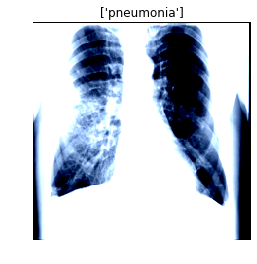

In [13]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [14]:
outputs = model(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  pneumonia
Ground Truth:  pneumonia


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        labels = get_onehot_encodings(labels)
        outputs = model(images)
        outputs = sigmoid(outputs)
        mask = outputs >= 0.5
        outputs = mask.type(torch.DoubleTensor)
        total += labels.size(0)
        correct += accuracy_score(labels, outputs, normalize=False)

accuracy = 100 * correct / total
print(f'Accuracy of the network on {total} validation images: {accuracy}')

# Preparing CSV file

In [17]:
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [18]:
predictions = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        outputs = sigmoid(outputs)
        mask = outputs >= 0.5
        outputs = mask.type(torch.DoubleTensor)
#         print(outputs)
        predictions.append(outputs)
#         if len(predictions) == 100:
#             break

In [19]:
b = torch.Tensor(629, 3).double()
torch.cat(predictions, dim=0, out=b)
final_predictions = b.numpy()

In [20]:
df = pd.DataFrame(data=final_predictions, columns=['covid', 'normal', 'pneumonia'])

In [21]:
# Fix order using https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f
test_folder_path = Path(data_dir + '/Test/unknown')
filenames = []
for file in test_folder_path.iterdir():
    filenames.append(file.name)

In [22]:
df['Name'] = filenames

In [23]:
df.to_csv('my_predictions.csv', index=False, columns=['Name', 'covid', 'pneumonia', 'normal'])